/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.035900,0.064356,0.985969
2,0.020900,0.057438,0.988976
3,0.014500,0.055612,0.989087
4,0.000200,0.070736,0.989644
5,0.045400,0.081673,0.989198


Evaluation Metrics: {'eval_loss': 0.0707361027598381, 'eval_accuracy': 0.9896436525612472, 'eval_runtime': 31.7203, 'eval_samples_per_second': 283.1, 'eval_steps_per_second': 17.717, 'epoch': 5.0}

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4649
           1       0.99      0.99      0.99      4331

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



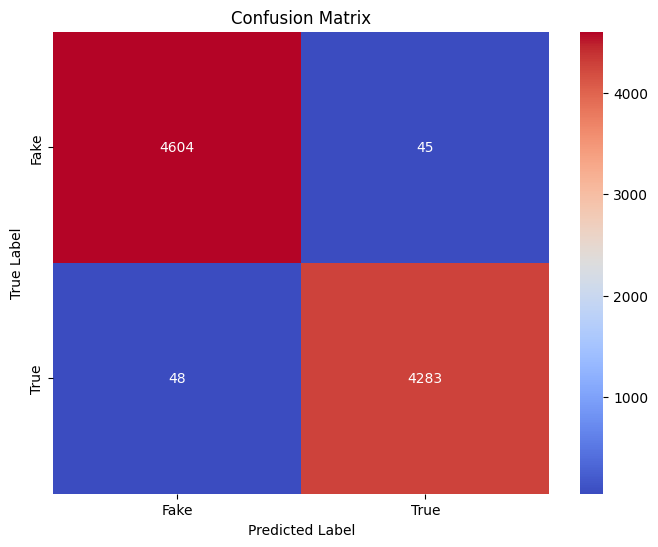

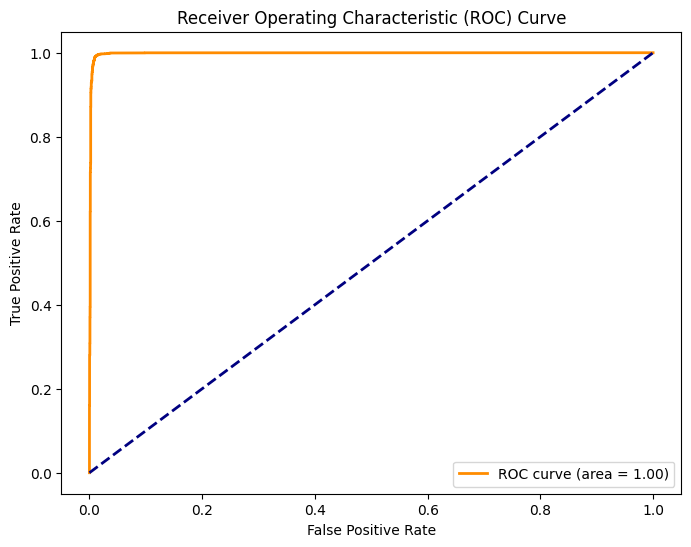

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset

# Load the datasets
fake_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
true_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')

# Label the datasets
fake_df['label'] = 0  # Fake news
true_df['label'] = 1  # True news

# Combine datasets
data = pd.concat([fake_df, true_df], ignore_index=True)

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Use 'title' column as features and 'label' as target
X = data['title']
y = data['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenization using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_texts(texts, labels, tokenizer, max_length=128):
    encodings = tokenizer(
        list(texts),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    encodings['labels'] = torch.tensor(labels.values)
    return encodings

train_encodings = encode_texts(X_train, y_train, tokenizer)
test_encodings = encode_texts(X_test, y_test, tokenizer)

# Convert encodings into a dataset format compatible with Trainer
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.encodings.items()}

train_dataset = NewsDataset(train_encodings)
test_dataset = NewsDataset(test_encodings)

# Load pre-trained BERT model with classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    run_name="fake-news-detection",
    report_to="none"
)

# Define a function to compute metrics
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
metrics = trainer.evaluate()
print("Evaluation Metrics:", metrics)

# Get predictions
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Improved confusion matrix visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=True, xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotting the ROC curve
fpr, tpr, _ = roc_curve(y_test, predictions.predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [10]:
# Save the trained model and tokenizer
model.save_pretrained("saved_model")
tokenizer.save_pretrained("saved_model")


('saved_model/tokenizer_config.json',
 'saved_model/special_tokens_map.json',
 'saved_model/vocab.txt',
 'saved_model/added_tokens.json')